# Draft visualization

In [10]:
!pip install scikit-image

     |████████████████████████████████| 14.0 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 92.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 93.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 89.8 MB/s eta 0:00:01
     |████████████████████████████████| 33.8 MB 84.6 MB/s eta 0:00:01
     |████████████████████████████████| 210 kB 94.9 MB/s eta 0:00:01


In [11]:
import matplotlib.pyplot as plt
import nibabel
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.transform import rescale

In [4]:
root = Path('/anvar/public_datasets/preproc_study/bgpd/') # 1_reg/255_18'
img = nibabel.load(root / '1_reg' / '255_18' / 'FLAIR.nii.gz')# .get_fdata()

def prep_for_pic(img):
    zooms = img.header.get_zooms()
    x = rescale(img.get_fdata(), zooms)
    y = x[..., 170].T
    y = y[::-1, :]
    y = y[40:210, :]
    y2 = y[100:140, 30:70]
    return y, y2

img2 = nibabel.load(root / '1_reg' / '255_18' / 'FLAIR.nii.gz')

y, y2 = prep_for_pic(img)

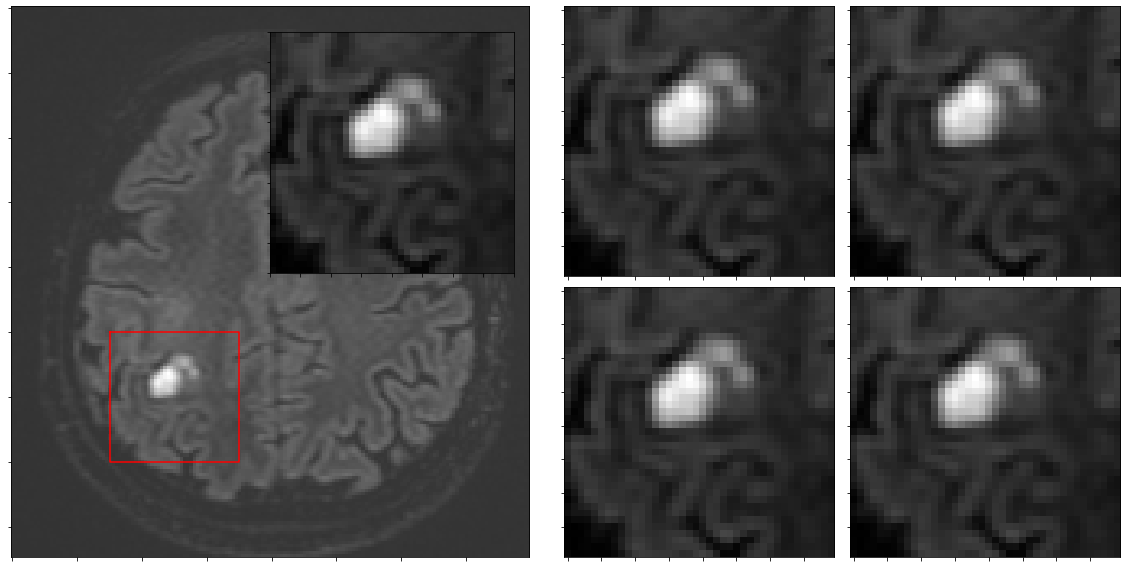

In [141]:
fig = plt.figure(figsize=(16,8))
ax0 = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
ax0.imshow(y, cmap='gray', alpha=0.8);

ax1 = plt.subplot2grid((2, 4), (0, 2))
ax2 = plt.subplot2grid((2, 4), (0, 3))
ax3 = plt.subplot2grid((2, 4), (1, 2))
ax4 = plt.subplot2grid((2, 4), (1, 3))

ax1.imshow(y2, cmap='gray');
ax2.imshow(y2, cmap='gray');
ax3.imshow(y2, cmap='gray');
ax4.imshow(y2, cmap='gray');

axins = ax0.inset_axes([0.5, 0.5, 0.47, 0.47])
axins.imshow(y2[::-1, :], cmap='gray', extent=(100, 140, 30, 70), origin='lower')


for ax in [ax0, ax1, ax2, ax3, ax4, axins]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

ax0.plot([30,70,70,30, 30], [100, 100, 140, 140, 100], c='r')
    
plt.tight_layout()

# Histogram matching comparison

In [142]:
# Check for FLAIR

In [337]:
def compute_kl(img, brain, mask):
    size, _bins = np.histogram(img[brain.astype(bool)], 30)
    bins = [(_bins[i]+_bins[i+1])/2 for i in range(len(_bins)-1)]

    size_healthy, _ = np.histogram(img[brain.astype(bool)^mask.astype(bool)].reshape(-1), bins=_bins)
    size_tumor, _ = np.histogram(img[mask.astype(bool)].reshape(-1), bins=_bins)

    size_healthy = np.round(size_healthy/size_healthy.sum(), 5)
    size_tumor = np.round(size_tumor/size_tumor.sum(), 5)
    
    size_healthy = np.where(size_healthy>10e-6, size_healthy, 10e-6)
    size_tumor = np.where(size_tumor>10e-6, size_tumor, 10e-6)

    kl_dist = 0
    for h,t in zip(size_healthy, size_tumor):
        kl_dist += h * np.log2(h/t)
            
    return kl_dist, size_healthy, size_tumor, _bins

In [4]:
from tqdm import tqdm

In [201]:
root = Path('/anvar/public_datasets/preproc_study/bgpd/5_ss_shared') # 1_reg/255_18'

all_kl = []

for patient in tqdm(root.glob('*')):
    if patient.is_dir():
        img = nibabel.load(patient / 'FLAIR.nii.gz').get_fdata()
        mask = nibabel.load(patient / 'mask_GTV_FLAIR.nii.gz').get_fdata()
        brain = nibabel.load(patient / 'FLAIR_mask.nii.gz').get_fdata()
        
        kl, _, _, _ = compute_kl(img, brain, mask)
        all_kl.append(kl)

181it [02:52,  1.05it/s]


In [202]:
# from dpipe.im.visualize import slice3d

In [203]:
# slice3d(img, mask, brain, img+500*mask+500*brain)

In [204]:
# # plt.plot(bins, size/size.sum())
# plt.plot(bins, size_healthy/size_healthy.sum())
# plt.plot(bins, size_tumor/size_tumor.sum());

In [215]:
np.median(all_kl), np.std(all_kl)

(1.1653123888188215, 0.757604589112512)

In [208]:
root2 = Path('/anvar/public_datasets/preproc_study/bgpd/6_hist/6_hist_fold_0/')

all_kl2 = []

for patient in tqdm(root2.glob('*')):
    if patient.is_dir():
        img = nibabel.load(patient / 'FLAIR.nii.gz').get_fdata()
        mask = nibabel.load(patient / 'mask_GTV_FLAIR.nii.gz').get_fdata()
        brain = nibabel.load(root / patient.name / 'FLAIR_mask.nii.gz').get_fdata()
        
        kl, _, _, _ = compute_kl(img, brain, mask)
        all_kl2.append(kl)

180it [03:06,  1.04s/it]


In [231]:
root3 = Path('/anvar/public_datasets/preproc_study/bgpd/3b_n4')

all_kl3 = []

for patient in tqdm(root3.glob('*')):
    if patient.is_dir():
        try:
            img = nibabel.load(patient / 'FLAIR.nii.gz').get_fdata()
            mask = nibabel.load(patient / 'mask_GTV_FLAIR.nii.gz').get_fdata()
            brain = nibabel.load(root / patient.name / 'FLAIR_mask.nii.gz').get_fdata()

            kl, _, _, _ = compute_kl(img, brain, mask)
            all_kl3.append(kl)
        except:
            pass

181it [02:27,  1.22it/s]


In [216]:
np.median(all_kl2), np.std(all_kl2)

(1.0456530402363642, 0.7781776202089244)

In [228]:
enum = []
for i,(a,b) in enumerate(zip(all_kl, all_kl2)):
    if np.round(a,3)-np.round(b,3) < 0.5:
        enum.append(i)

In [34]:
from scipy.stats import wilcoxon

In [226]:
wilcoxon(np.array(all_kl)[enum], np.array(all_kl2)[enum])

WilcoxonResult(statistic=4941.0, pvalue=0.0004337401585069546)

In [233]:
wilcoxon(np.array(all_kl)[enum], np.array(all_kl3)[enum])

WilcoxonResult(statistic=1457.0, pvalue=2.523245323586608e-19)

In [234]:
wilcoxon(np.array(all_kl), np.array(all_kl3))

WilcoxonResult(statistic=1501.0, pvalue=2.291101906744818e-21)

In [236]:
np.mean(all_kl3)

0.8520227441784101

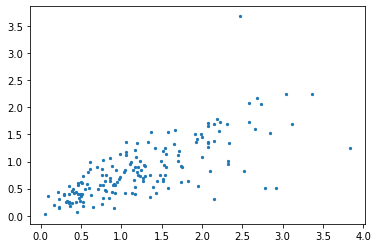

In [235]:
plt.scatter(np.array(all_kl)[enum], np.array(all_kl3)[enum], s=5)

# Skull-stripping Volumes vs Tumor

In [262]:
volumes = []
for patient in tqdm(root.glob('*')):
    if patient.is_dir():
        try:
            mask = nibabel.load(patient / 'mask_GTV_FLAIR.nii.gz')
            brain = nibabel.load(root / patient.name / 'FLAIR_mask.nii.gz')
            zooms = mask.header.get_zooms()
            px_volume = np.array(zooms).prod()

            mask_volume = mask.get_fdata().sum() * px_volume
            brain_volume = brain.get_fdata().sum() * px_volume
            truncated_mask = mask.get_fdata()[np.logical_and(mask.get_fdata().astype(bool),
                                                 brain.get_fdata().astype(bool))]
            truncated_mask_volume = truncated_mask.sum() * px_volume
            volumes.append([brain_volume, mask_volume, truncated_mask_volume])
        except:
            pass

181it [01:04,  2.83it/s]


In [263]:
import pandas as pd

In [275]:
df = pd.DataFrame(volumes, columns=['brain', 'mask', 'trunc'])

In [276]:
df['rel_error'] = (df['mask'] - df['trunc']) / df['mask']
df['mask, ml'] = df['mask'] / 1000
df['abs_error, ml'] = df['rel_error'] * df['mask, ml']
df['rel_error, %'] = df['rel_error'] * 100

In [278]:
df['abs_error, ml'].agg(['mean', 'median', 'std'])

mean      0.384887
median    0.005658
std       2.138250
Name: abs_error, ml, dtype: float64

In [279]:
df['rel_error, %'].agg(['mean', 'median', 'std'])

mean      0.264877
median    0.010917
std       0.878040
Name: rel_error, %, dtype: float64

In [289]:
df[df['abs_error, ml'] < 1]['abs_error, ml']

0      0.250018
2      0.729200
3      0.025917
4      0.000000
5      0.007914
         ...   
175    0.103298
176    0.022535
177    0.008960
178    0.042096
179    0.000000
Name: abs_error, ml, Length: 168, dtype: float64

In [298]:
df[df['abs_error, ml']>1.0]

,brain,mask,trunc,rel_error,"mask, ml","abs_error, ml","rel_error, %"
1,1624693.0,263601.179760,260071.859252,0.013389,263.601180,3.529321,1.338886
11,1587975.0,252318.491203,248512.043672,0.015086,252.318491,3.806448,1.508588
13,1663891.0,463720.697764,436262.136462,0.059214,463.720698,27.458561,5.921358
18,1256425.0,231884.055795,230330.383224,0.006700,231.884056,1.553673,0.670021
19,1371377.0,190319.716359,189029.557817,0.006779,190.319716,1.290159,0.677890
45,1465498.0,229100.883206,226589.300946,0.010963,229.100883,2.511582,1.096278
51,1322029.0,325862.395966,324467.636208,0.004280,325.862396,1.394760,0.428021
60,1430550.0,136109.214456,132231.376534,0.028491,136.109214,3.877838,2.849063
107,1414713.0,158234.259731,157139.626632,0.006918,158.234260,1.094633,0.691780
110,1443152.0,44377.230146,41740.184234,0.059423,44.377230,2.637046,5.942340


In [328]:
df[df['rel_error, %']>1].shape

(10, 7)

12 / 180 ~ 6.5% наблюдений это ошибка более 1 мл объема.

In [300]:
root

PosixPath('/anvar/public_datasets/preproc_study/bgpd/5_ss_shared')

In [306]:
root_gbm = Path('/anvar/public_datasets/preproc_study/gbm/5_ss_shared')

In [318]:
volumes = []
for patient in tqdm(root_gbm.glob('*')):
    if patient.is_dir():
        try:
            brain = nibabel.load(patient / 'CT1_mask.nii.gz')
            mask = nibabel.load(patient / 'CT1_SEG.nii.gz')
            zooms = mask.header.get_zooms()
            px_volume = np.array(zooms).prod()
            mask = np.round(mask.get_fdata()).astype(bool).astype(int)
            
            
            mask_volume = mask.sum() * px_volume
            brain_volume = brain.get_fdata().sum() * px_volume
            truncated_mask = mask[np.logical_and(mask.astype(bool),
                                                 brain.get_fdata().astype(bool))]
            truncated_mask_volume = truncated_mask.sum() * px_volume
            volumes.append([brain_volume, mask_volume, truncated_mask_volume])
        except:
            pass

103it [00:42,  2.41it/s]


In [319]:
df2 = pd.DataFrame(volumes, columns=['brain', 'mask', 'trunc'])
df2['rel_error'] = (df2['mask'] - df2['trunc']) / df2['mask']
df2['mask, ml'] = df2['mask'] / 1000
df2['abs_error, ml'] = df2['rel_error'] * df2['mask, ml']
df2['rel_error, %'] = df2['rel_error'] * 100

In [320]:
df2

,brain,mask,trunc,rel_error,"mask, ml","abs_error, ml","rel_error, %"
0,1451713.0,214734.0,214424.0,0.001444,214.734,0.310,0.144365
1,1521958.0,16587.0,16587.0,0.000000,16.587,0.000,0.000000
2,1460420.0,179832.0,179292.0,0.003003,179.832,0.540,0.300280
3,1318938.0,152192.0,150518.0,0.010999,152.192,1.674,1.099926
4,1516522.0,175571.0,167567.0,0.045588,175.571,8.004,4.558839
...,...,...,...,...,...,...,...
97,1381609.0,32848.0,32847.0,0.000030,32.848,0.001,0.003044
98,1429995.0,183869.0,182310.0,0.008479,183.869,1.559,0.847886
99,1459389.0,142891.0,142891.0,0.000000,142.891,0.000,0.000000
100,1377192.0,142699.0,142699.0,0.000000,142.699,0.000,0.000000


In [323]:
df2[df2['abs_error, ml']>1]

,brain,mask,trunc,rel_error,"mask, ml","abs_error, ml","rel_error, %"
3,1318938.0,152192.0,150518.0,0.010999,152.192,1.674,1.099926
4,1516522.0,175571.0,167567.0,0.045588,175.571,8.004,4.558839
11,1444791.0,182169.0,156128.0,0.142950,182.169,26.041,14.294968
17,1589144.0,207722.0,203414.0,0.020739,207.722,4.308,2.073926
29,1662357.0,73359.0,71656.0,0.023215,73.359,1.703,2.321460
31,1334334.0,106131.0,104293.0,0.017318,106.131,1.838,1.731822
33,1483735.0,55308.0,53192.0,0.038258,55.308,2.116,3.825848
36,1400073.0,74898.0,71287.0,0.048212,74.898,3.611,4.821224
47,1583269.0,231492.0,223188.0,0.035872,231.492,8.304,3.587165
77,1550516.0,151725.0,146101.0,0.037067,151.725,5.624,3.706706


12 / 102 ~ 12% наблюдений это ошибка более чем на 1 мл.

In [327]:
df2[df2['rel_error, %']>1].shape

(11, 7)

# Volumes Atlas+SS vs Atlas


Резюмирую про объемы, посчитал оценку объема опухоли для 3_atlas, 5_ss и истинный объем, получается что различия между 3_atlas и 5_ss - измеримые (ошибка оценки объема для 5_ss в среднем на 2 мл лучше), но статистически не очень значимые, pvalue 0.1, при этом pvalue различий между GT и Atlas 0.35, а pvalue различий между GT и Atlas+SS - 0.65. Т.е. в целом оценки получаются хорошие.

In [19]:
import json
import os

In [52]:
def pred_invert_resample(path_to_pred, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
    if np.shape(data)[0] == 1:
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
    
    # gbm and lgg
    elif np.shape(data)[0] > 1:
        data = data.transpose(0,3,2,1).astype('float32')

        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)

        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])

        new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1, False, 0)
        new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1, False, 0)
        new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1, False, 0)

        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.transpose(0,3,2,1).astype('float16')
    return (output_file)

def pred_invert_resample_1cl(data, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
        if new_orig.shape[0]-output_file.shape[0] < 0:
            output_file = output_file[:new_orig.shape[0], :new_orig.shape[1],:new_orig.shape[2] ]
        elif new_orig.shape[0]-output_file.shape[0] > 0:
            output_file = np.pad(output_file, ((0, new_orig.shape[0]-output_file.shape[0]), (0, new_orig.shape[1]-output_file.shape[1]), (0, new_orig.shape[2]-output_file.shape[2])), 'constant', constant_values=0)

        return (output_file)
    
def pred_invert_resample_classes(data, mat_file_path, path_to_orig, path_to_resampled, mod):

    # gbm and lgg
        data = data.transpose(0,3,2,1).astype('float32')
#         print(data.shape)
        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)
    
#         print(old_orig_ct1.shape)
#         print(new_orig_ct1.shape)
        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])
#         print('old_like')
# #         print(old_like_ch_2.shape)
        if mod == '2a_interp':
            new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.shape, True, 0)
            new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.shape, True, 0)
            new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.shape, True, 0)
        if mod == '3a_atlas':
            new_img_0 = ants.apply_transforms(new_orig_ct1, old_like_ch_0, whichtoinvert=[True],
                                          transformlist = mat_file_path)
            new_img_1 = ants.apply_transforms(new_orig_ct1, old_like_ch_1, whichtoinvert=[True],
                                          transformlist = mat_file_path)
            new_img_2 = ants.apply_transforms(new_orig_ct1, old_like_ch_2, whichtoinvert=[True],
                                          transformlist = mat_file_path)
        else:
            new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.spacing, False, 0)
            new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.spacing, False, 0)
            new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.spacing, False, 0)
       
        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.astype('float16')
#         print(output_file.shape)
#         print('check_shape')
#         print(new_orig_ct1.shape)
#         print(new_orig_ct1.shape[2]-output_file.shape[3])
#         print((new_orig_ct1.shape[1]-output_file.shape[2]))
#         print((new_orig_ct1.shape[0]-output_file.shape[1]))
        if (new_orig_ct1.shape[2]-output_file.shape[3] < 0 ) or (new_orig_ct1.shape[1]-output_file.shape[2] < 0) or (new_orig_ct1.shape[0]-output_file.shape[1] < 0):
            print(1)
            output_file = output_file[:, :new_orig_ct1.shape[0], :new_orig_ct1.shape[1],:new_orig_ct1.shape[2] ]
            
        if (new_orig_ct1.shape[2]-output_file.shape[3] > 0) or (new_orig_ct1.shape[1]-output_file.shape[2] > 0 ) or (new_orig_ct1.shape[0]-output_file.shape[1] > 0):
            print(2)
            output_file = np.pad(output_file, ((0,0), (0, new_orig_ct1.shape[0]-output_file.shape[1]), (0, new_orig_ct1.shape[1]-output_file.shape[2]), (0, new_orig_ct1.shape[2]-output_file.shape[3])), 'constant', constant_values=0)

        output_file = output_file[:,:new_orig_ct1.shape[0], :new_orig_ct1.shape[1],:new_orig_ct1.shape[2] ]
#         print(output_file.shape)
        
        return (output_file)

In [50]:
predictions = Path('/mnt/experiments/gbm_infer')

In [51]:
os.listdir(predictions)

['gbm_5_ss_shared',
 '6_histogram_fold_2',
 '6_histogram_fold_0',
 'gbm_4a_resamp_unetr_param',
 'gbm_5_ss_shared_unetr_param',
 'gbm_4b_n4_unetr_param',
 'gbm_4d_susan_unetr_param',
 'gbm_4a_resamp_wo_z',
 'gbm_4a_resamp',
 'gbm_1_reg_train',
 'gbm_4b_n4',
 'gbm_2a_interp',
 '6_histogram_fold_1',
 'gbm_4d_susan',
 'gbm_3a_atlas',
 'gbm_4a_resamp_ct1',
 'gbm_4a_resamp_100',
 'gbm_4a_resamp_flair',
 'gbm_4a_resamp_aug']

In [ ]:
with open(folds/'gbm_seed.json', 'r') as f:
    patients = json.load(f)

In [17]:
list(predictions.glob('*'))

[]

In [6]:
folder_predicts_ss = Path('/anvar/public_datasets/preproc_study/gbm/inference/native_space/5_ss')
folder_predicts_atlas = Path('/anvar/public_datasets/preproc_study/gbm/inference/native_space/3a_atlas')
folds = Path('/home/anvar/projects/brain-mri-processing-pipeline/main_pipeline/utils')
folder_mask = Path('/anvar/public_datasets/preproc_study/gbm/1_reg/')

In [7]:
with open(folds/'gbm_seed.json', 'r') as f:
    patients = json.load(f)

In [8]:
# x = np.load(folder_predicts / 'fold=0' / 'TCGA-02-0009.npz')

In [9]:
def get_arrays(folder, files):
    for file in files:
        arr = np.load(folder / f'{file}.npz')['arr_0']
        yield arr

In [10]:
patients.keys()

dict_keys(['fold_0', 'fold_1', 'fold_2'])

In [11]:
folds_names = patients['fold_0']
folds_names.extend(patients['fold_1'])
folds_names.extend(patients['fold_2'])

In [12]:
# 5 skull stripping
test_predicts_ss = []

# fold 0, 1, 2
fold_0 = [arr for arr in get_arrays(folder_predicts_ss / 'fold=0', patients['fold_0'])]
fold_1 = [arr for arr in get_arrays(folder_predicts_ss / 'fold=1', patients['fold_1'])]
fold_2 = [arr for arr in get_arrays(folder_predicts_ss / 'fold=2', patients['fold_2'])]

test_predicts_ss.extend(fold_0)
test_predicts_ss.extend(fold_1)
test_predicts_ss.extend(fold_2)

# 3 atlas
test_predicts_atlas = []

# fold 0, 1, 2
fold_0 = [arr for arr in get_arrays(folder_predicts_atlas / 'fold=0', patients['fold_0'])]
fold_1 = [arr for arr in get_arrays(folder_predicts_atlas / 'fold=1', patients['fold_1'])]
fold_2 = [arr for arr in get_arrays(folder_predicts_atlas / 'fold=2', patients['fold_2'])]

test_predicts_atlas.extend(fold_0)
test_predicts_atlas.extend(fold_1)
test_predicts_atlas.extend(fold_2)

FileNotFoundError: [Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/gbm/inference/native_space/5_ss/fold=0/TCGA-02-0011.npz'

In [47]:
mask_pred = [nibabel.load(folder_mask / sub / 'CT1_SEG.nii.gz').get_fdata() for sub in folds_names]

In [48]:
# IMAGES

images = [nibabel.load(folder_mask / sub / 'CT1.nii.gz') for sub in folds_names]

In [393]:
len(test_predicts_ss), len(test_predicts_atlas), len(mask_pred)

(102, 102, 102)

## Compute volumes

In [49]:
volumes_ml_ss = []
volumes_ml_atlas = []
volumes_ml_true = []

for _ss, _atlas, true, im in zip(test_predicts_ss, test_predicts_atlas, mask_pred, images):
    img_px_vol = np.prod(im.header.get_zooms())
    ss_volume = np.sum(np.round(_ss), axis=0).astype(bool).sum() * img_px_vol / 1000
    atlas_volume = np.sum(np.round(_atlas), axis=0).astype(bool).sum() * img_px_vol / 1000
    true_volume = true.astype(bool).sum() * img_px_vol / 1000
    
    volumes_ml_ss.append(ss_volume)
    volumes_ml_atlas.append(atlas_volume)
    volumes_ml_true.append(true_volume)

In [441]:
ss_volume, atlas_volume, true_volume

(106846.923828125, 122660.5224609375, 126782.53173828125)

In [454]:
volumes_ml_true = np.array(volumes_ml_true)
volumes_ml_atlas = np.array(volumes_ml_atlas)
volumes_ml_ss = np.array(volumes_ml_ss)

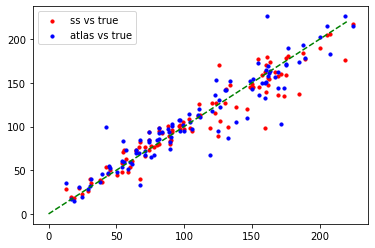

In [448]:
plt.plot([0, 220], [0, 220], ls='--', color='g')
plt.scatter(volumes_ml_true, volumes_ml_ss, s=10, c='r', label='ss vs true')
plt.scatter(volumes_ml_true, volumes_ml_atlas, s = 10, c='b', label='atlas vs true')
plt.legend();

In [36]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [491]:
mean_absolute_percentage_error(volumes_ml_true, volumes_ml_atlas)

0.14390973782658575

In [492]:
mean_absolute_percentage_error(volumes_ml_true, volumes_ml_ss)

0.11599403391143118

In [450]:
mean_absolute_error(volumes_ml_true, volumes_ml_atlas)

12.079199424984408

In [451]:
mean_absolute_error(volumes_ml_true, volumes_ml_ss)

10.650897088602479

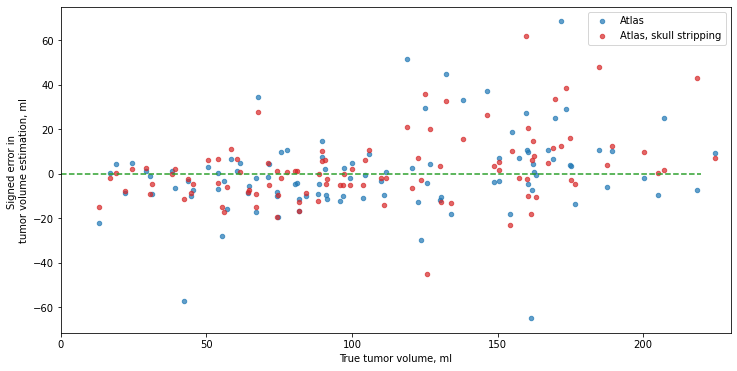

In [488]:
# Bland-Altman-like

# plt.plot([0, 220], [0, 220], ls='--', color='g')

plt.figure(figsize=(12,6))
plt.scatter(volumes_ml_true, volumes_ml_true-volumes_ml_atlas, s = 20, alpha=0.7, c='tab:blue', label='Atlas')
plt.scatter(volumes_ml_true, volumes_ml_true-volumes_ml_ss, s=20, alpha=0.7, c='tab:red', label='Atlas, skull stripping')
plt.hlines(0, 0, 220, linestyles='--', colors='tab:green')
plt.xlim(0, 230)
plt.xlabel('True tumor volume, ml')
plt.ylabel('Signed error in \ntumor volume estimation, ml')
plt.legend();

In [457]:
wilcoxon(volumes_ml_atlas, volumes_ml_ss)

WilcoxonResult(statistic=2140.0, pvalue=0.1043703723079587)

In [459]:
wilcoxon(volumes_ml_atlas, volumes_ml_true)

WilcoxonResult(statistic=2363.0, pvalue=0.3790701218717454)

In [460]:
wilcoxon(volumes_ml_ss, volumes_ml_true)

WilcoxonResult(statistic=2484.0, pvalue=0.634294594786418)

In [461]:
wilcoxon(volumes_ml_true - volumes_ml_ss, volumes_ml_true - volumes_ml_atlas)

WilcoxonResult(statistic=2140.0, pvalue=0.1043703723079587)

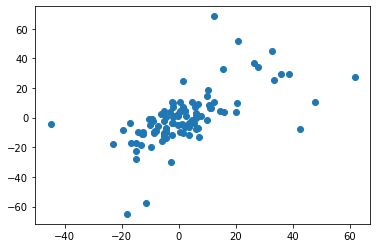

In [485]:
plt.scatter(volumes_ml_true - volumes_ml_ss, volumes_ml_true - volumes_ml_atlas)

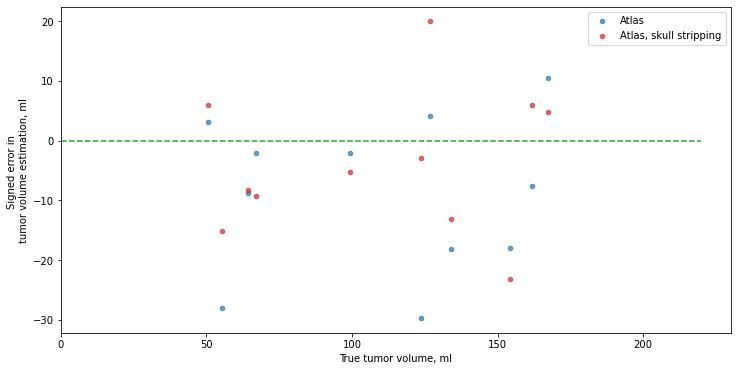

In [489]:
# Bland-Altman-like

# plt.plot([0, 220], [0, 220], ls='--', color='g')

plt.figure(figsize=(12,6))
plt.scatter(volumes_ml_true[::10], volumes_ml_true[::10]-volumes_ml_atlas[::10], s = 20, alpha=0.7, c='tab:blue', label='Atlas')
plt.scatter(volumes_ml_true[::10], volumes_ml_true[::10]-volumes_ml_ss[::10], s=20, alpha=0.7, c='tab:red', label='Atlas, skull stripping')
plt.hlines(0, 0, 220, linestyles='--', colors='tab:green')
plt.xlim(0, 230)
plt.xlabel('True tumor volume, ml')
plt.ylabel('Signed error in \ntumor volume estimation, ml')
plt.legend();


# Volumes other exp

In [7]:
patients.keys()

dict_keys(['fold_0', 'fold_1', 'fold_2'])

In [18]:
def get_volumes_exp(folder, patients, images):
    # collect_predicts
    predicts = []

    # fold 0, 1, 2
    fold_0 = [arr for arr in get_arrays(folder / 'fold=0', patients['fold_0'])]
    fold_1 = [arr for arr in get_arrays(folder / 'fold=1', patients['fold_1'])]
    fold_2 = [arr for arr in get_arrays(folder / 'fold=2', patients['fold_2'])]

    predicts.extend(fold_0)
    predicts.extend(fold_1)
    predicts.extend(fold_2)
    
    volumes_ml_true = []
    
    for pred, im in zip(predicts, images):
        img_px_vol = np.prod(im.header.get_zooms())
        volume = np.sum(np.round(pred), axis=0).astype(bool).sum() * img_px_vol / 1000
        volumes_ml_true.append(volume)
    
    return np.array(volumes_ml_true)

In [14]:
root = Path('/anvar/public_datasets/preproc_study/gbm/inference/native_space/')

In [15]:
from tqdm import tqdm
import numpy as np

In [22]:
all_predicts = dict()

In [25]:
for experiment in tqdm(root.glob('*')):
    if experiment.name not in ['5_ss_mask_native', '6_hist', '4a_resamp_aug', '3a_atlas', '3b_n4']:
        if experiment.is_dir():
            key = experiment.name
            values = get_volumes_exp(experiment, patients, images)
            np.save(f'/home/anvar/{key}_volumes', values)
            all_predicts[key] = values

13it [10:11, 47.05s/it]


In [26]:
all_predicts.keys()

dict_keys(['4a_resamp_aug', '3a_atlas', '3b_n4', '2a_interp', '3d_susan', '5_ss', '3c_n4_susan', '4a_resamp', '3a_atlas_aug'])

In [29]:
# True Volume

mask_pred = [nibabel.load(folder_mask / sub / 'CT1_SEG.nii.gz').get_fdata() for sub in folds_names]

In [30]:
volumes_ml_true = []
for true, im in zip(mask_pred, images):
    img_px_vol = np.prod(im.header.get_zooms())
    true_volume = true.astype(bool).sum() * img_px_vol / 1000
    volumes_ml_true.append(true_volume)

In [31]:
np.save(f'/home/anvar/true_volumes', volumes_ml_true)

In [32]:
all_predicts['true_volume'] = volumes_ml_true

In [37]:
for key, val in all_predicts.items():
    mae = mean_absolute_error(volumes_ml_true, val)
    wil = wilcoxon(volumes_ml_true, val)
    print(key)
    print(mae)
    print(wil)
    print('=======')

4a_resamp_aug
9.46123154434854
WilcoxonResult(statistic=2537.0, pvalue=0.7651176211180126)
3a_atlas
10.309481750044167
WilcoxonResult(statistic=2100.0, pvalue=0.07882363956125471)
3b_n4
12.65667088378177
WilcoxonResult(statistic=2016.0, pvalue=0.04155393110500976)
2a_interp
10.90868653320331
WilcoxonResult(statistic=2392.5, pvalue=0.4347230409085989)
3d_susan
10.388771479843879
WilcoxonResult(statistic=2261.0, pvalue=0.2224248960622499)
5_ss
9.244942059584693
WilcoxonResult(statistic=1538.0, pvalue=0.0002794821855839156)
3c_n4_susan
13.892532490383177
WilcoxonResult(statistic=1644.0, pvalue=0.0010389407610051273)
4a_resamp
11.85439789777994
WilcoxonResult(statistic=1731.0, pvalue=0.002795791384868947)
3a_atlas_aug
9.26858450215003
WilcoxonResult(statistic=2254.0, pvalue=0.21369367988596422)


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [50]:
volumes_ml_ss

[106.846923828125,
 98.19427490234375,
 89.22821044921875,
 175.8062744140625,
 80.03204345703125,
 120.07200631642341,
 95.484619140625,
 184.0271484375,
 126.815625,
 145.27984619140625,
 44.641845703125,
 109.0283203125,
 53.321044921875,
 97.37062063932419,
 79.62721231675148,
 35.817026232123375,
 26.767305588006973,
 47.49609375,
 71.83679345858097,
 181.166748046875,
 76.33005065917969,
 53.64749450683594,
 97.90226934814453,
 145.29523315429688,
 205.80474243164062,
 73.00568885803223,
 93.67561340332031,
 83.92354316568375,
 139.8711251453161,
 159.58648828125,
 155.8716064453125,
 98.00231915283203,
 66.46183203935624,
 204.86744384765626,
 36.19354248046875,
 96.19160515499115,
 98.6029052734375,
 169.05792236328125,
 94.46802229213715,
 22.423095703125,
 66.23779296875,
 144.52294921875,
 44.2265625,
 116.6693115234375,
 86.37506103515625,
 51.38470458984375,
 46.63789248466492,
 127.037109375,
 137.21044921875,
 14.268142700195312,
 159.2644875512123,
 78.19209178233146,
 

In [51]:
all_predicts['5_ss']

array([106.84692383,  98.1942749 ,  89.22821045, 175.80627441,
        80.03204346, 120.07200632,  95.48461914, 184.02714844,
       126.815625  , 145.27984619,  44.6418457 , 109.02832031,
        53.32104492,  97.37062064,  79.62721232,  35.81702623,
        26.76730559,  47.49609375,  71.83679346, 181.16674805,
        76.33005066,  53.64749451,  97.90226935, 145.29523315,
       205.80474243,  73.00568886,  93.6756134 ,  83.92354317,
       139.87112515, 159.58648828, 155.87160645,  98.00231915,
        66.46183204, 204.86744385,  36.19354248,  96.19160515,
        98.60290527, 169.05792236,  94.46802229,  22.4230957 ,
        66.23779297, 144.52294922,  44.2265625 , 116.66931152,
        86.37506104,  51.38470459,  46.63789248, 127.03710938,
       137.21044922,  14.2681427 , 159.26448755,  78.19209178,
       138.270457  , 106.34188843, 159.1770813 , 160.41332703,
        65.93831635,  45.2295105 ,  17.9612051 , 212.44109192,
        56.25109285, 134.251     , 145.536     , 123.95